# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 978us/sample - loss: 229.3149 - y1_output_loss: 109.3630 - y2_output_loss: 117.9289 - y1_output_root_mean_squared_error: 10.5059 - y2_output_root_mean_squared_error: 10.9060 - val_loss: 33.0515 - val_y1_output_loss: 13.8969 - val_y2_output_loss: 20.7036 - val_y1_output_root_mean_squared_error: 3.6698 - val_y2_output_root_mean_squared_error: 4.4254
Epoch 2/500
614/614 [==============================] - 0s 145us/sample - loss: 30.7196 - y1_output_loss: 12.6144 - y2_output_loss: 17.8534 - y1_output_root_mean_squared_error: 3.5676 - y2_output_root_mean_squared_error: 4.2416 - val_loss: 23.0334 - val_y1_output_loss: 9.8003 - val_y2_output_loss: 14.1269 - val_y1_output_root_mean_squared_error: 3.0837 - val_y2_output_root_mean_squared_error: 3.6775
Epoch 3/500
614/614 [==============================] - 0s 137us/sample - loss: 27.0540 - y1_output_loss: 10.5335 - y2_output_loss: 16.3442 - y1_

614/614 [==============================] - 0s 136us/sample - loss: 14.8652 - y1_output_loss: 5.6525 - y2_output_loss: 9.1893 - y1_output_root_mean_squared_error: 2.3802 - y2_output_root_mean_squared_error: 3.0331 - val_loss: 13.6503 - val_y1_output_loss: 4.6498 - val_y2_output_loss: 8.7984 - val_y1_output_root_mean_squared_error: 2.1783 - val_y2_output_root_mean_squared_error: 2.9842
Epoch 22/500
614/614 [==============================] - 0s 138us/sample - loss: 17.0519 - y1_output_loss: 6.2432 - y2_output_loss: 10.6557 - y1_output_root_mean_squared_error: 2.5096 - y2_output_root_mean_squared_error: 3.2793 - val_loss: 12.0728 - val_y1_output_loss: 4.8133 - val_y2_output_loss: 7.6757 - val_y1_output_root_mean_squared_error: 2.1728 - val_y2_output_root_mean_squared_error: 2.7114
Epoch 23/500
614/614 [==============================] - 0s 137us/sample - loss: 16.4395 - y1_output_loss: 6.1357 - y2_output_loss: 10.4187 - y1_output_root_mean_squared_error: 2.4730 - y2_output_root_mean_squared

614/614 [==============================] - 0s 141us/sample - loss: 8.2686 - y1_output_loss: 2.8201 - y2_output_loss: 5.4039 - y1_output_root_mean_squared_error: 1.6864 - y2_output_root_mean_squared_error: 2.3291 - val_loss: 6.9431 - val_y1_output_loss: 2.2840 - val_y2_output_loss: 4.6554 - val_y1_output_root_mean_squared_error: 1.5277 - val_y2_output_root_mean_squared_error: 2.1469
Epoch 42/500
614/614 [==============================] - 0s 138us/sample - loss: 8.4210 - y1_output_loss: 2.9579 - y2_output_loss: 5.3989 - y1_output_root_mean_squared_error: 1.7278 - y2_output_root_mean_squared_error: 2.3315 - val_loss: 6.5951 - val_y1_output_loss: 2.5595 - val_y2_output_loss: 4.1365 - val_y1_output_root_mean_squared_error: 1.6065 - val_y2_output_root_mean_squared_error: 2.0036
Epoch 43/500
614/614 [==============================] - 0s 135us/sample - loss: 8.0101 - y1_output_loss: 2.8456 - y2_output_loss: 5.1739 - y1_output_root_mean_squared_error: 1.6877 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 136us/sample - loss: 6.9904 - y1_output_loss: 2.2697 - y2_output_loss: 4.7576 - y1_output_root_mean_squared_error: 1.5096 - y2_output_root_mean_squared_error: 2.1706 - val_loss: 10.4255 - val_y1_output_loss: 1.9933 - val_y2_output_loss: 8.7023 - val_y1_output_root_mean_squared_error: 1.4226 - val_y2_output_root_mean_squared_error: 2.8986
Epoch 63/500
614/614 [==============================] - 0s 133us/sample - loss: 8.1040 - y1_output_loss: 2.8636 - y2_output_loss: 5.1851 - y1_output_root_mean_squared_error: 1.6958 - y2_output_root_mean_squared_error: 2.2866 - val_loss: 4.2489 - val_y1_output_loss: 1.1529 - val_y2_output_loss: 3.1003 - val_y1_output_root_mean_squared_error: 1.0913 - val_y2_output_root_mean_squared_error: 1.7487
Epoch 64/500
614/614 [==============================] - 0s 141us/sample - loss: 6.6656 - y1_output_loss: 1.9663 - y2_output_loss: 4.6685 - y1_output_root_mean_squared_error: 1.4065 - y2_output_root_mean_

Epoch 83/500
614/614 [==============================] - 0s 129us/sample - loss: 2.8386 - y1_output_loss: 0.7213 - y2_output_loss: 2.1218 - y1_output_root_mean_squared_error: 0.8473 - y2_output_root_mean_squared_error: 1.4563 - val_loss: 2.9550 - val_y1_output_loss: 0.3890 - val_y2_output_loss: 2.6560 - val_y1_output_root_mean_squared_error: 0.6292 - val_y2_output_root_mean_squared_error: 1.5997
Epoch 84/500
614/614 [==============================] - 0s 129us/sample - loss: 3.0534 - y1_output_loss: 0.7527 - y2_output_loss: 2.2850 - y1_output_root_mean_squared_error: 0.8651 - y2_output_root_mean_squared_error: 1.5182 - val_loss: 2.8310 - val_y1_output_loss: 0.7649 - val_y2_output_loss: 2.1390 - val_y1_output_root_mean_squared_error: 0.8636 - val_y2_output_root_mean_squared_error: 1.4440
Epoch 85/500
614/614 [==============================] - 0s 130us/sample - loss: 2.6842 - y1_output_loss: 0.6312 - y2_output_loss: 2.0480 - y1_output_root_mean_squared_error: 0.7946 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 130us/sample - loss: 2.3412 - y1_output_loss: 0.5118 - y2_output_loss: 1.8304 - y1_output_root_mean_squared_error: 0.7178 - y2_output_root_mean_squared_error: 1.3513 - val_loss: 2.5499 - val_y1_output_loss: 0.5482 - val_y2_output_loss: 2.0582 - val_y1_output_root_mean_squared_error: 0.7355 - val_y2_output_root_mean_squared_error: 1.4174
Epoch 105/500
614/614 [==============================] - 0s 135us/sample - loss: 3.4716 - y1_output_loss: 0.7427 - y2_output_loss: 2.7023 - y1_output_root_mean_squared_error: 0.8636 - y2_output_root_mean_squared_error: 1.6510 - val_loss: 3.8636 - val_y1_output_loss: 1.0344 - val_y2_output_loss: 2.9784 - val_y1_output_root_mean_squared_error: 0.9870 - val_y2_output_root_mean_squared_error: 1.6998
Epoch 106/500
614/614 [==============================] - 0s 132us/sample - loss: 2.8126 - y1_output_loss: 0.6200 - y2_output_loss: 2.1941 - y1_output_root_mean_squared_error: 0.7872 - y2_output_root_mea

614/614 [==============================] - 0s 143us/sample - loss: 2.2440 - y1_output_loss: 0.4392 - y2_output_loss: 1.7935 - y1_output_root_mean_squared_error: 0.6649 - y2_output_root_mean_squared_error: 1.3423 - val_loss: 2.8110 - val_y1_output_loss: 0.7080 - val_y2_output_loss: 2.1463 - val_y1_output_root_mean_squared_error: 0.8401 - val_y2_output_root_mean_squared_error: 1.4509
Epoch 125/500
614/614 [==============================] - 0s 139us/sample - loss: 3.4612 - y1_output_loss: 0.6616 - y2_output_loss: 2.8002 - y1_output_root_mean_squared_error: 0.8166 - y2_output_root_mean_squared_error: 1.6716 - val_loss: 3.6025 - val_y1_output_loss: 0.6373 - val_y2_output_loss: 2.9029 - val_y1_output_root_mean_squared_error: 0.7776 - val_y2_output_root_mean_squared_error: 1.7314
Epoch 126/500
614/614 [==============================] - 0s 148us/sample - loss: 1.9793 - y1_output_loss: 0.4710 - y2_output_loss: 1.5301 - y1_output_root_mean_squared_error: 0.6839 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 138us/sample - loss: 1.5497 - y1_output_loss: 0.3478 - y2_output_loss: 1.1939 - y1_output_root_mean_squared_error: 0.5916 - y2_output_root_mean_squared_error: 1.0953 - val_loss: 1.5520 - val_y1_output_loss: 0.2844 - val_y2_output_loss: 1.3040 - val_y1_output_root_mean_squared_error: 0.5267 - val_y2_output_root_mean_squared_error: 1.1290
Epoch 146/500
614/614 [==============================] - 0s 140us/sample - loss: 1.6511 - y1_output_loss: 0.3597 - y2_output_loss: 1.2995 - y1_output_root_mean_squared_error: 0.5961 - y2_output_root_mean_squared_error: 1.1383 - val_loss: 1.8306 - val_y1_output_loss: 0.3798 - val_y2_output_loss: 1.4532 - val_y1_output_root_mean_squared_error: 0.6232 - val_y2_output_root_mean_squared_error: 1.2009
Epoch 147/500
614/614 [==============================] - 0s 146us/sample - loss: 1.5855 - y1_output_loss: 0.3205 - y2_output_loss: 1.2667 - y1_output_root_mean_squared_error: 0.5669 - y2_output_root_mea

614/614 [==============================] - 0s 143us/sample - loss: 1.4609 - y1_output_loss: 0.3009 - y2_output_loss: 1.1512 - y1_output_root_mean_squared_error: 0.5495 - y2_output_root_mean_squared_error: 1.0766 - val_loss: 1.5267 - val_y1_output_loss: 0.2831 - val_y2_output_loss: 1.2589 - val_y1_output_root_mean_squared_error: 0.5320 - val_y2_output_root_mean_squared_error: 1.1152
Epoch 166/500
614/614 [==============================] - 0s 144us/sample - loss: 1.9201 - y1_output_loss: 0.4763 - y2_output_loss: 1.4616 - y1_output_root_mean_squared_error: 0.6925 - y2_output_root_mean_squared_error: 1.2002 - val_loss: 2.9190 - val_y1_output_loss: 0.4111 - val_y2_output_loss: 2.5439 - val_y1_output_root_mean_squared_error: 0.6354 - val_y2_output_root_mean_squared_error: 1.5859
Epoch 167/500
614/614 [==============================] - 0s 140us/sample - loss: 1.6253 - y1_output_loss: 0.3055 - y2_output_loss: 1.3082 - y1_output_root_mean_squared_error: 0.5539 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 139us/sample - loss: 1.7567 - y1_output_loss: 0.3414 - y2_output_loss: 1.4129 - y1_output_root_mean_squared_error: 0.5862 - y2_output_root_mean_squared_error: 1.1887 - val_loss: 1.4621 - val_y1_output_loss: 0.2506 - val_y2_output_loss: 1.1826 - val_y1_output_root_mean_squared_error: 0.4909 - val_y2_output_root_mean_squared_error: 1.1051
Epoch 187/500
614/614 [==============================] - 0s 141us/sample - loss: 1.1461 - y1_output_loss: 0.2432 - y2_output_loss: 0.9115 - y1_output_root_mean_squared_error: 0.4924 - y2_output_root_mean_squared_error: 0.9506 - val_loss: 3.1810 - val_y1_output_loss: 0.2558 - val_y2_output_loss: 3.0174 - val_y1_output_root_mean_squared_error: 0.4952 - val_y2_output_root_mean_squared_error: 1.7134
Epoch 188/500
614/614 [==============================] - 0s 154us/sample - loss: 1.1160 - y1_output_loss: 0.2254 - y2_output_loss: 0.8824 - y1_output_root_mean_squared_error: 0.4770 - y2_output_root_mea

614/614 [==============================] - 0s 136us/sample - loss: 1.6822 - y1_output_loss: 0.3878 - y2_output_loss: 1.3334 - y1_output_root_mean_squared_error: 0.6255 - y2_output_root_mean_squared_error: 1.1362 - val_loss: 8.0329 - val_y1_output_loss: 0.8149 - val_y2_output_loss: 7.8293 - val_y1_output_root_mean_squared_error: 0.8565 - val_y2_output_root_mean_squared_error: 2.7017
Epoch 207/500
614/614 [==============================] - 0s 140us/sample - loss: 1.1699 - y1_output_loss: 0.2395 - y2_output_loss: 0.9267 - y1_output_root_mean_squared_error: 0.4908 - y2_output_root_mean_squared_error: 0.9638 - val_loss: 1.5779 - val_y1_output_loss: 0.2567 - val_y2_output_loss: 1.3740 - val_y1_output_root_mean_squared_error: 0.5042 - val_y2_output_root_mean_squared_error: 1.1505
Epoch 208/500
614/614 [==============================] - 0s 139us/sample - loss: 0.9942 - y1_output_loss: 0.2166 - y2_output_loss: 0.7728 - y1_output_root_mean_squared_error: 0.4660 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 142us/sample - loss: 1.6909 - y1_output_loss: 0.3592 - y2_output_loss: 1.3185 - y1_output_root_mean_squared_error: 0.6018 - y2_output_root_mean_squared_error: 1.1527 - val_loss: 1.3683 - val_y1_output_loss: 0.3551 - val_y2_output_loss: 1.0386 - val_y1_output_root_mean_squared_error: 0.5879 - val_y2_output_root_mean_squared_error: 1.0113
Epoch 228/500
614/614 [==============================] - 0s 143us/sample - loss: 1.3015 - y1_output_loss: 0.2667 - y2_output_loss: 1.0281 - y1_output_root_mean_squared_error: 0.5171 - y2_output_root_mean_squared_error: 1.0169 - val_loss: 2.1585 - val_y1_output_loss: 0.4606 - val_y2_output_loss: 1.7980 - val_y1_output_root_mean_squared_error: 0.6650 - val_y2_output_root_mean_squared_error: 1.3101
Epoch 229/500
614/614 [==============================] - 0s 143us/sample - loss: 1.1793 - y1_output_loss: 0.2673 - y2_output_loss: 0.9042 - y1_output_root_mean_squared_error: 0.5182 - y2_output_root_mea

614/614 [==============================] - 0s 145us/sample - loss: 1.2917 - y1_output_loss: 0.2718 - y2_output_loss: 1.0158 - y1_output_root_mean_squared_error: 0.5223 - y2_output_root_mean_squared_error: 1.0094 - val_loss: 2.0301 - val_y1_output_loss: 0.4021 - val_y2_output_loss: 1.8204 - val_y1_output_root_mean_squared_error: 0.5913 - val_y2_output_root_mean_squared_error: 1.2963
Epoch 248/500
614/614 [==============================] - 0s 144us/sample - loss: 0.8165 - y1_output_loss: 0.1914 - y2_output_loss: 0.6215 - y1_output_root_mean_squared_error: 0.4391 - y2_output_root_mean_squared_error: 0.7898 - val_loss: 0.9089 - val_y1_output_loss: 0.1719 - val_y2_output_loss: 0.7484 - val_y1_output_root_mean_squared_error: 0.4126 - val_y2_output_root_mean_squared_error: 0.8594
Epoch 249/500
614/614 [==============================] - 0s 141us/sample - loss: 0.9600 - y1_output_loss: 0.1916 - y2_output_loss: 0.7635 - y1_output_root_mean_squared_error: 0.4391 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 137us/sample - loss: 0.7524 - y1_output_loss: 0.1602 - y2_output_loss: 0.5931 - y1_output_root_mean_squared_error: 0.3991 - y2_output_root_mean_squared_error: 0.7701 - val_loss: 2.3835 - val_y1_output_loss: 0.2641 - val_y2_output_loss: 2.2380 - val_y1_output_root_mean_squared_error: 0.4995 - val_y2_output_root_mean_squared_error: 1.4608
Epoch 269/500
614/614 [==============================] - 0s 137us/sample - loss: 0.8753 - y1_output_loss: 0.2114 - y2_output_loss: 0.6672 - y1_output_root_mean_squared_error: 0.4565 - y2_output_root_mean_squared_error: 0.8166 - val_loss: 1.5771 - val_y1_output_loss: 0.2411 - val_y2_output_loss: 1.3815 - val_y1_output_root_mean_squared_error: 0.4812 - val_y2_output_root_mean_squared_error: 1.1600
Epoch 270/500
614/614 [==============================] - 0s 138us/sample - loss: 0.6629 - y1_output_loss: 0.1602 - y2_output_loss: 0.5048 - y1_output_root_mean_squared_error: 0.4015 - y2_output_root_mea

614/614 [==============================] - 0s 144us/sample - loss: 0.7228 - y1_output_loss: 0.2028 - y2_output_loss: 0.5181 - y1_output_root_mean_squared_error: 0.4514 - y2_output_root_mean_squared_error: 0.7204 - val_loss: 1.6005 - val_y1_output_loss: 0.2405 - val_y2_output_loss: 1.4163 - val_y1_output_root_mean_squared_error: 0.4759 - val_y2_output_root_mean_squared_error: 1.1722
Epoch 289/500
614/614 [==============================] - 0s 142us/sample - loss: 0.9607 - y1_output_loss: 0.1874 - y2_output_loss: 0.7819 - y1_output_root_mean_squared_error: 0.4322 - y2_output_root_mean_squared_error: 0.8797 - val_loss: 1.4280 - val_y1_output_loss: 0.4359 - val_y2_output_loss: 1.0318 - val_y1_output_root_mean_squared_error: 0.6442 - val_y2_output_root_mean_squared_error: 1.0065
Epoch 290/500
614/614 [==============================] - 0s 141us/sample - loss: 0.9244 - y1_output_loss: 0.2149 - y2_output_loss: 0.7203 - y1_output_root_mean_squared_error: 0.4656 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 140us/sample - loss: 0.7066 - y1_output_loss: 0.1788 - y2_output_loss: 0.5241 - y1_output_root_mean_squared_error: 0.4243 - y2_output_root_mean_squared_error: 0.7257 - val_loss: 0.9565 - val_y1_output_loss: 0.1652 - val_y2_output_loss: 0.7674 - val_y1_output_root_mean_squared_error: 0.4037 - val_y2_output_root_mean_squared_error: 0.8908
Epoch 310/500
614/614 [==============================] - 0s 141us/sample - loss: 0.6618 - y1_output_loss: 0.1667 - y2_output_loss: 0.4898 - y1_output_root_mean_squared_error: 0.4102 - y2_output_root_mean_squared_error: 0.7026 - val_loss: 0.9119 - val_y1_output_loss: 0.2266 - val_y2_output_loss: 0.6885 - val_y1_output_root_mean_squared_error: 0.4747 - val_y2_output_root_mean_squared_error: 0.8286
Epoch 311/500
614/614 [==============================] - 0s 140us/sample - loss: 0.6100 - y1_output_loss: 0.1559 - y2_output_loss: 0.4537 - y1_output_root_mean_squared_error: 0.3943 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 0.6184 - y1_output_loss: 0.1695 - y2_output_loss: 0.4479 - y1_output_root_mean_squared_error: 0.4134 - y2_output_root_mean_squared_error: 0.6689 - val_loss: 0.8647 - val_y1_output_loss: 0.2731 - val_y2_output_loss: 0.5947 - val_y1_output_root_mean_squared_error: 0.5116 - val_y2_output_root_mean_squared_error: 0.7765
Epoch 330/500
614/614 [==============================] - 0s 143us/sample - loss: 0.4868 - y1_output_loss: 0.1319 - y2_output_loss: 0.3563 - y1_output_root_mean_squared_error: 0.3648 - y2_output_root_mean_squared_error: 0.5948 - val_loss: 1.3496 - val_y1_output_loss: 0.2248 - val_y2_output_loss: 1.1629 - val_y1_output_root_mean_squared_error: 0.4726 - val_y2_output_root_mean_squared_error: 1.0612
Epoch 331/500
614/614 [==============================] - 0s 144us/sample - loss: 0.5674 - y1_output_loss: 0.1344 - y2_output_loss: 0.4286 - y1_output_root_mean_squared_error: 0.3677 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 137us/sample - loss: 0.7440 - y1_output_loss: 0.1931 - y2_output_loss: 0.5536 - y1_output_root_mean_squared_error: 0.4398 - y2_output_root_mean_squared_error: 0.7420 - val_loss: 1.8735 - val_y1_output_loss: 0.3110 - val_y2_output_loss: 1.5972 - val_y1_output_root_mean_squared_error: 0.5474 - val_y2_output_root_mean_squared_error: 1.2546
Epoch 351/500
614/614 [==============================] - 0s 139us/sample - loss: 0.7311 - y1_output_loss: 0.1710 - y2_output_loss: 0.5545 - y1_output_root_mean_squared_error: 0.4152 - y2_output_root_mean_squared_error: 0.7475 - val_loss: 0.6657 - val_y1_output_loss: 0.1823 - val_y2_output_loss: 0.4891 - val_y1_output_root_mean_squared_error: 0.4209 - val_y2_output_root_mean_squared_error: 0.6990
Epoch 352/500
614/614 [==============================] - 0s 136us/sample - loss: 0.9533 - y1_output_loss: 0.2076 - y2_output_loss: 0.7529 - y1_output_root_mean_squared_error: 0.4521 - y2_output_root_mea

614/614 [==============================] - 0s 141us/sample - loss: 0.4774 - y1_output_loss: 0.1298 - y2_output_loss: 0.3574 - y1_output_root_mean_squared_error: 0.3565 - y2_output_root_mean_squared_error: 0.5918 - val_loss: 1.5663 - val_y1_output_loss: 0.3136 - val_y2_output_loss: 1.2557 - val_y1_output_root_mean_squared_error: 0.5651 - val_y2_output_root_mean_squared_error: 1.1167
Epoch 371/500
614/614 [==============================] - 0s 138us/sample - loss: 0.4995 - y1_output_loss: 0.1407 - y2_output_loss: 0.3577 - y1_output_root_mean_squared_error: 0.3757 - y2_output_root_mean_squared_error: 0.5986 - val_loss: 1.0177 - val_y1_output_loss: 0.1869 - val_y2_output_loss: 0.8391 - val_y1_output_root_mean_squared_error: 0.4330 - val_y2_output_root_mean_squared_error: 0.9111
Epoch 372/500
614/614 [==============================] - 0s 141us/sample - loss: 0.5593 - y1_output_loss: 0.1464 - y2_output_loss: 0.4116 - y1_output_root_mean_squared_error: 0.3820 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 141us/sample - loss: 0.5643 - y1_output_loss: 0.1433 - y2_output_loss: 0.4180 - y1_output_root_mean_squared_error: 0.3792 - y2_output_root_mean_squared_error: 0.6484 - val_loss: 1.8361 - val_y1_output_loss: 0.4319 - val_y2_output_loss: 1.5264 - val_y1_output_root_mean_squared_error: 0.6334 - val_y2_output_root_mean_squared_error: 1.1979
Epoch 392/500
614/614 [==============================] - 0s 148us/sample - loss: 0.4752 - y1_output_loss: 0.1326 - y2_output_loss: 0.3398 - y1_output_root_mean_squared_error: 0.3639 - y2_output_root_mean_squared_error: 0.5854 - val_loss: 0.6320 - val_y1_output_loss: 0.1835 - val_y2_output_loss: 0.4364 - val_y1_output_root_mean_squared_error: 0.4294 - val_y2_output_root_mean_squared_error: 0.6690
Epoch 393/500
614/614 [==============================] - 0s 147us/sample - loss: 0.3670 - y1_output_loss: 0.1197 - y2_output_loss: 0.2446 - y1_output_root_mean_squared_error: 0.3476 - y2_output_root_mea

614/614 [==============================] - 0s 152us/sample - loss: 0.5207 - y1_output_loss: 0.1599 - y2_output_loss: 0.3604 - y1_output_root_mean_squared_error: 0.4003 - y2_output_root_mean_squared_error: 0.6004 - val_loss: 0.9747 - val_y1_output_loss: 0.2554 - val_y2_output_loss: 0.7082 - val_y1_output_root_mean_squared_error: 0.5047 - val_y2_output_root_mean_squared_error: 0.8485
Epoch 412/500
614/614 [==============================] - 0s 141us/sample - loss: 0.6274 - y1_output_loss: 0.1625 - y2_output_loss: 0.4762 - y1_output_root_mean_squared_error: 0.4002 - y2_output_root_mean_squared_error: 0.6836 - val_loss: 3.7331 - val_y1_output_loss: 0.5912 - val_y2_output_loss: 3.2158 - val_y1_output_root_mean_squared_error: 0.7700 - val_y2_output_root_mean_squared_error: 1.7720
Epoch 413/500
614/614 [==============================] - 0s 144us/sample - loss: 0.5436 - y1_output_loss: 0.1510 - y2_output_loss: 0.3900 - y1_output_root_mean_squared_error: 0.3898 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 139us/sample - loss: 0.3853 - y1_output_loss: 0.1244 - y2_output_loss: 0.2603 - y1_output_root_mean_squared_error: 0.3532 - y2_output_root_mean_squared_error: 0.5105 - val_loss: 0.7147 - val_y1_output_loss: 0.1881 - val_y2_output_loss: 0.5080 - val_y1_output_root_mean_squared_error: 0.4359 - val_y2_output_root_mean_squared_error: 0.7243
Epoch 433/500
614/614 [==============================] - 0s 142us/sample - loss: 0.3865 - y1_output_loss: 0.1156 - y2_output_loss: 0.2677 - y1_output_root_mean_squared_error: 0.3414 - y2_output_root_mean_squared_error: 0.5196 - val_loss: 0.5903 - val_y1_output_loss: 0.1916 - val_y2_output_loss: 0.3858 - val_y1_output_root_mean_squared_error: 0.4395 - val_y2_output_root_mean_squared_error: 0.6302
Epoch 434/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6159 - y1_output_loss: 0.1802 - y2_output_loss: 0.4325 - y1_output_root_mean_squared_error: 0.4263 - y2_output_root_mea

614/614 [==============================] - 0s 141us/sample - loss: 0.3939 - y1_output_loss: 0.1290 - y2_output_loss: 0.2636 - y1_output_root_mean_squared_error: 0.3603 - y2_output_root_mean_squared_error: 0.5139 - val_loss: 0.8425 - val_y1_output_loss: 0.2366 - val_y2_output_loss: 0.5874 - val_y1_output_root_mean_squared_error: 0.4890 - val_y2_output_root_mean_squared_error: 0.7768
Epoch 453/500
614/614 [==============================] - 0s 141us/sample - loss: 0.3117 - y1_output_loss: 0.1065 - y2_output_loss: 0.2041 - y1_output_root_mean_squared_error: 0.3278 - y2_output_root_mean_squared_error: 0.4519 - val_loss: 0.5950 - val_y1_output_loss: 0.1537 - val_y2_output_loss: 0.4265 - val_y1_output_root_mean_squared_error: 0.3972 - val_y2_output_root_mean_squared_error: 0.6612
Epoch 454/500
614/614 [==============================] - 0s 140us/sample - loss: 0.6469 - y1_output_loss: 0.1977 - y2_output_loss: 0.4455 - y1_output_root_mean_squared_error: 0.4456 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 139us/sample - loss: 0.4488 - y1_output_loss: 0.1224 - y2_output_loss: 0.3238 - y1_output_root_mean_squared_error: 0.3508 - y2_output_root_mean_squared_error: 0.5707 - val_loss: 0.7430 - val_y1_output_loss: 0.2110 - val_y2_output_loss: 0.5564 - val_y1_output_root_mean_squared_error: 0.4497 - val_y2_output_root_mean_squared_error: 0.7354
Epoch 474/500
614/614 [==============================] - 0s 144us/sample - loss: 0.2976 - y1_output_loss: 0.1144 - y2_output_loss: 0.1808 - y1_output_root_mean_squared_error: 0.3395 - y2_output_root_mean_squared_error: 0.4271 - val_loss: 0.5743 - val_y1_output_loss: 0.1739 - val_y2_output_loss: 0.3849 - val_y1_output_root_mean_squared_error: 0.4213 - val_y2_output_root_mean_squared_error: 0.6299
Epoch 475/500
614/614 [==============================] - 0s 139us/sample - loss: 0.3454 - y1_output_loss: 0.1304 - y2_output_loss: 0.2127 - y1_output_root_mean_squared_error: 0.3622 - y2_output_root_mea

614/614 [==============================] - 0s 142us/sample - loss: 0.4559 - y1_output_loss: 0.1190 - y2_output_loss: 0.3334 - y1_output_root_mean_squared_error: 0.3462 - y2_output_root_mean_squared_error: 0.5797 - val_loss: 0.7651 - val_y1_output_loss: 0.2471 - val_y2_output_loss: 0.5349 - val_y1_output_root_mean_squared_error: 0.4790 - val_y2_output_root_mean_squared_error: 0.7319
Epoch 494/500
614/614 [==============================] - 0s 137us/sample - loss: 0.3815 - y1_output_loss: 0.1159 - y2_output_loss: 0.2663 - y1_output_root_mean_squared_error: 0.3416 - y2_output_root_mean_squared_error: 0.5146 - val_loss: 0.6161 - val_y1_output_loss: 0.1660 - val_y2_output_loss: 0.4322 - val_y1_output_root_mean_squared_error: 0.4106 - val_y2_output_root_mean_squared_error: 0.6689
Epoch 495/500
614/614 [==============================] - 0s 141us/sample - loss: 0.2820 - y1_output_loss: 0.1023 - y2_output_loss: 0.1858 - y1_output_root_mean_squared_error: 0.3174 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 36us/sample - loss: 0.9293 - y1_output_loss: 0.1940 - y2_output_loss: 0.7273 - y1_output_root_mean_squared_error: 0.4402 - y2_output_root_mean_squared_error: 0.8577
Loss = 0.9293392246419733, Y1_loss = 0.1940010040998459, Y1_mse = 0.44017305970191956, Y2_loss = 0.727349042892456, Y2_mse = 0.857663631439209


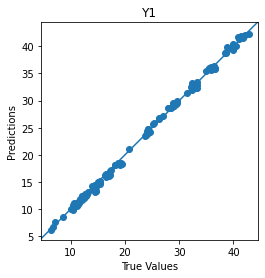

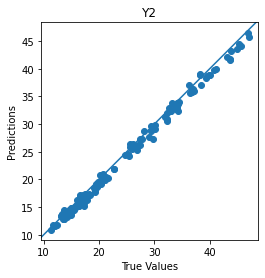

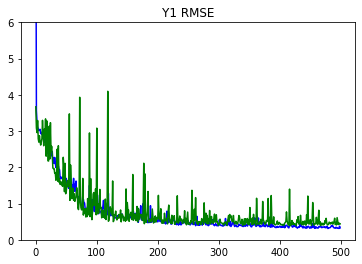

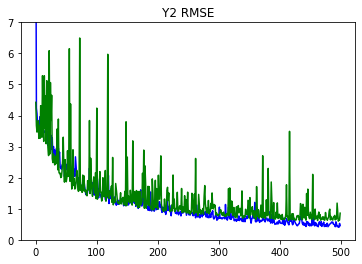

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)